This notebook tries to reproduce the results from the adversarial spheres paper: https://arxiv.org/pdf/1801.02774.pdf

We also study the effect the norm of the data has on learning.
We generate spheres of radius $O(1)$ and $O(\sqrt{D})$.
The radius $O(\sqrt{D})$ setting is meant to model how image inputs are fed into NNs in practice.

### Import dependencies

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import ProjectedGradientDescent

tf.config.list_physical_devices(device_type=None)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Data generation utils

In [2]:
def normalize_vectors(xs):
    return xs / np.linalg.norm(xs, ord=2, axis=1, keepdims=True)

def sample_unit_sphere(num_samples, dim):
    return normalize_vectors(
        np.random.normal(size=(num_samples, dim))
    )

def generate_sphere_data(dim, r1, r2, num_samples):
    assert num_samples % 2 == 0
    
    xs = np.concatenate([
        r1 * sample_unit_sphere(num_samples // 2, dim),
        r2 * sample_unit_sphere(num_samples // 2, dim)
    ])
    
    ys = np.concatenate([
        np.zeros(shape=num_samples // 2, dtype=np.int64),
        np.ones(shape=num_samples // 2, dtype=np.int64)
    ])
    
    perm = np.random.permutation(num_samples)
    xs = xs[perm]
    ys = ys[perm]
    
    return xs, ys

generate_sphere_data(dim=2, r1=1, r2=10, num_samples=4)

(array([[ 5.39207939,  8.42172666],
        [-8.73155622, -4.87441546],
        [-0.21834208,  0.97587229],
        [ 0.69347835, -0.72047746]]),
 array([1, 1, 0, 0], dtype=int64))

### Experiment setup

In [3]:
def run_experiment(
    dim,
    r1, r2,
    model_layers,
    train_epochs,
    attack_norm,
    attack_eps,
    attack_eps_step,
    attack_iters,
    train_batch_size=64,
    attack_batch_size=256,
    num_train=5 * 10 ** 4,
    num_test=10 ** 4,
    seed=42
):
    """
    Default values for num_train and num_test are size of CIFAR10 dataset.
    
    Keras code derived from https://keras.io/examples/vision/mnist_convnet/.
    
    ART code derived from https://github.com/Trusted-AI/adversarial-robustness-toolbox/blob/main/notebooks/adversarial_retraining.ipynb
    and https://github.com/Trusted-AI/adversarial-robustness-toolbox/issues/238.
    """
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
    x_train, y_train = generate_sphere_data(
        dim=dim, r1=r1, r2=r2,
        num_samples=num_train,
    )

    x_test, y_test = generate_sphere_data(
        dim=dim, r1=r1, r2=r2,
        num_samples=num_test,
    )
    
    model = keras.Sequential(
        [keras.Input(shape=x_train[0].shape)]
        + model_layers
    )
    model.compile(
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer="adam",
        metrics=["accuracy"]
    )
    model.fit(
        x_train,
        y_train,
        batch_size=train_batch_size,
        epochs=train_epochs,
        validation_data=(x_test, y_test),
        verbose=2,
    )
    model.trainable = False
    
    art_model = TensorFlowV2Classifier(
        model=model,
        input_shape=x_test[0].shape,
        nb_classes=2,
        loss_object=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        clip_values=[-x_test.max(), x_test.max()],
    )
    art_attack = ProjectedGradientDescent(
        art_model,
        norm=attack_norm,
        eps=attack_eps,
        eps_step=attack_eps_step,
        max_iter=attack_iters,
        batch_size=attack_batch_size,
    )
    
    x_train_adv = art_attack.generate(x_train[:num_test], y=y_train[:num_test])    
    x_test_adv = art_attack.generate(x_test, y=y_test)
    
    _, nat_train_acc = model.evaluate(x_train, y_train, verbose=0)
    _, nat_test_acc = model.evaluate(x_test, y_test, verbose=0)
    _, adv_train_acc = model.evaluate(x_train_adv, y_train[:num_test], verbose=0)
    _, adv_test_acc = model.evaluate(x_test_adv, y_test, verbose=0)
    
    print("Nat train acc :", nat_train_acc)
    print("Nat test  acc :", nat_test_acc)
    print("Adv train acc :", adv_train_acc)
    print("Adv test  acc :", adv_test_acc)
    
    return dict(
        model=model,
        train_data=(x_train, y_train),
        test_data=(x_test, y_test),
        x_train_adv=x_train_adv,
        x_test_adv=x_test_adv,
    )

### Run experiments

Norm $O(1)$

In [4]:
%%time
D = 500
res = run_experiment(
    dim=D,
    r1=1.0, r2=1.3,
    model_layers=[
        layers.Dense(1000, activation="relu"),
        layers.Dense(1000, activation="relu"),
        layers.Dense(2),
    ],
    train_epochs=5,
    attack_norm=2,
    attack_eps=0.1,
    attack_eps_step=0.01,
    attack_iters=20,
)

Epoch 1/5
782/782 - 3s - loss: 0.0978 - accuracy: 0.9576 - val_loss: 0.0235 - val_accuracy: 0.9916
Epoch 2/5
782/782 - 1s - loss: 0.0137 - accuracy: 0.9950 - val_loss: 0.0232 - val_accuracy: 0.9920
Epoch 3/5
782/782 - 1s - loss: 0.0125 - accuracy: 0.9956 - val_loss: 0.0174 - val_accuracy: 0.9935
Epoch 4/5
782/782 - 1s - loss: 0.0079 - accuracy: 0.9972 - val_loss: 0.0211 - val_accuracy: 0.9929
Epoch 5/5
782/782 - 1s - loss: 0.0101 - accuracy: 0.9965 - val_loss: 0.0239 - val_accuracy: 0.9926


PGD - Batches: 0it [00:00, ?it/s]

PGD - Batches: 0it [00:00, ?it/s]

Nat train acc : 0.9979000091552734
Nat test  acc : 0.9926000237464905
Adv train acc : 0.39340001344680786
Adv test  acc : 0.3077000081539154
Wall time: 20.3 s


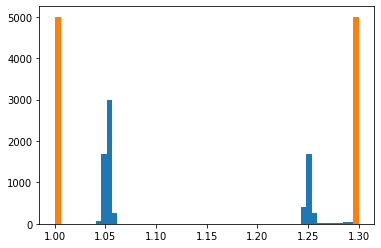

In [5]:
plt.hist(np.linalg.norm(res["x_test_adv"], ord=2, axis=-1), bins=50);
plt.hist(np.linalg.norm(res["test_data"][0], ord=2, axis=-1), bins=50);

---

Norm $O(\sqrt{D})$

In [6]:
%%time
D = 500
res = run_experiment(
    dim=D,
    r1=1.0 * np.sqrt(D), r2=1.3 * np.sqrt(D),
    model_layers=[
        layers.Dense(1000, activation="relu"),
        layers.Dense(1000, activation="relu"),
        layers.Dense(2),
    ],
    train_epochs=30,
    attack_norm=2,
    attack_eps=0.1 * np.sqrt(D),
    attack_eps_step=0.01 * np.sqrt(D),
    attack_iters=20,
)

Epoch 1/30
782/782 - 2s - loss: 0.6694 - accuracy: 0.5746 - val_loss: 0.6180 - val_accuracy: 0.6032
Epoch 2/30
782/782 - 1s - loss: 0.4113 - accuracy: 0.8133 - val_loss: 0.2954 - val_accuracy: 0.8772
Epoch 3/30
782/782 - 1s - loss: 0.1018 - accuracy: 0.9620 - val_loss: 0.2256 - val_accuracy: 0.9120
Epoch 4/30
782/782 - 1s - loss: 0.0504 - accuracy: 0.9818 - val_loss: 0.2739 - val_accuracy: 0.8952
Epoch 5/30
782/782 - 1s - loss: 0.0411 - accuracy: 0.9848 - val_loss: 0.2517 - val_accuracy: 0.9112
Epoch 6/30
782/782 - 1s - loss: 0.0356 - accuracy: 0.9869 - val_loss: 0.1566 - val_accuracy: 0.9396
Epoch 7/30
782/782 - 1s - loss: 0.0296 - accuracy: 0.9894 - val_loss: 0.1679 - val_accuracy: 0.9382
Epoch 8/30
782/782 - 1s - loss: 0.0254 - accuracy: 0.9906 - val_loss: 0.1310 - val_accuracy: 0.9525
Epoch 9/30
782/782 - 1s - loss: 0.0233 - accuracy: 0.9918 - val_loss: 0.1105 - val_accuracy: 0.9574
Epoch 10/30
782/782 - 1s - loss: 0.0215 - accuracy: 0.9927 - val_loss: 0.1817 - val_accuracy: 0.9335

PGD - Batches: 0it [00:00, ?it/s]

PGD - Batches: 0it [00:00, ?it/s]

Nat train acc : 0.998420000076294
Nat test  acc : 0.9811999797821045
Adv train acc : 0.39079999923706055
Adv test  acc : 0.2054000049829483
Wall time: 50.4 s


---

Norm $O(1)$ + BatchNorm

In [7]:
%%time
D = 500
res = run_experiment(
    dim=D,
    r1=1.0, r2=1.3,
    model_layers=[
        layers.Dense(1000, activation="relu"),
        layers.BatchNormalization(),
        layers.Dense(1000, activation="relu"),
        layers.Dense(2),
    ],
    train_epochs=5,
    attack_norm=2,
    attack_eps=0.1,
    attack_eps_step=0.01,
    attack_iters=20,
)

Epoch 1/5
782/782 - 2s - loss: 0.0437 - accuracy: 0.9828 - val_loss: 0.0132 - val_accuracy: 0.9961
Epoch 2/5
782/782 - 2s - loss: 0.0236 - accuracy: 0.9924 - val_loss: 0.0159 - val_accuracy: 0.9944
Epoch 3/5
782/782 - 2s - loss: 0.0215 - accuracy: 0.9925 - val_loss: 0.0310 - val_accuracy: 0.9903
Epoch 4/5
782/782 - 2s - loss: 0.0175 - accuracy: 0.9941 - val_loss: 0.0186 - val_accuracy: 0.9937
Epoch 5/5
782/782 - 2s - loss: 0.0200 - accuracy: 0.9935 - val_loss: 0.0381 - val_accuracy: 0.9890


PGD - Batches: 0it [00:00, ?it/s]

PGD - Batches: 0it [00:00, ?it/s]

Nat train acc : 0.9932199716567993
Nat test  acc : 0.9890000224113464
Adv train acc : 0.49889999628067017
Adv test  acc : 0.46399998664855957
Wall time: 22.8 s


---

Norm $O(\sqrt{D})$ + BatchNorm

In [8]:
%%time
D = 500
res = run_experiment(
    dim=D,
    r1=1.0 * np.sqrt(D), r2=1.3 * np.sqrt(D),
    model_layers=[
        layers.Dense(1000, activation="relu"),
        layers.BatchNormalization(),
        layers.Dense(1000, activation="relu"),
        layers.Dense(2),
    ],
    train_epochs=10,
    attack_norm=2,
    attack_eps=0.1 * np.sqrt(D),
    attack_eps_step=0.01 * np.sqrt(D),
    attack_iters=20,
)

Epoch 1/10
782/782 - 2s - loss: 0.0928 - accuracy: 0.9674 - val_loss: 0.0645 - val_accuracy: 0.9786
Epoch 2/10
782/782 - 2s - loss: 0.0634 - accuracy: 0.9772 - val_loss: 0.0341 - val_accuracy: 0.9878
Epoch 3/10
782/782 - 2s - loss: 0.0513 - accuracy: 0.9820 - val_loss: 0.0470 - val_accuracy: 0.9838
Epoch 4/10
782/782 - 2s - loss: 0.0400 - accuracy: 0.9867 - val_loss: 0.0346 - val_accuracy: 0.9882
Epoch 5/10
782/782 - 2s - loss: 0.0423 - accuracy: 0.9855 - val_loss: 0.0317 - val_accuracy: 0.9892
Epoch 6/10
782/782 - 2s - loss: 0.0379 - accuracy: 0.9870 - val_loss: 0.0219 - val_accuracy: 0.9927
Epoch 7/10
782/782 - 2s - loss: 0.0298 - accuracy: 0.9899 - val_loss: 0.0318 - val_accuracy: 0.9901
Epoch 8/10
782/782 - 2s - loss: 0.0286 - accuracy: 0.9902 - val_loss: 0.0305 - val_accuracy: 0.9892
Epoch 9/10
782/782 - 2s - loss: 0.0262 - accuracy: 0.9911 - val_loss: 0.0366 - val_accuracy: 0.9878
Epoch 10/10
782/782 - 2s - loss: 0.0230 - accuracy: 0.9924 - val_loss: 0.0334 - val_accuracy: 0.9878

PGD - Batches: 0it [00:00, ?it/s]

PGD - Batches: 0it [00:00, ?it/s]

Nat train acc : 0.9958599805831909
Nat test  acc : 0.9878000020980835
Adv train acc : 0.578000009059906
Adv test  acc : 0.48179998993873596
Wall time: 32.1 s


### Summary and conclusions

Our perturbation epsilon is chosen such that the max-margin classifier should have perfect robust accuracy.
However we see that our neural networks are far from robust.

Interestingly, it seems our neural networks train much quicker
when the data is of norm $O(1)$ compared to norm $O(\sqrt{D})$.
This difference can be mitigated with batchnorm.

It is also interesting to note that batchnorm seems to improve robustness.